# PySINDy SISO Model for Pressure control 

### Model Equation:
$$  x[k+1] = -2.176 1 + -0.202 x[k] + 0.014 u[k]^2$$

In [190]:
!virtualenv venv
%pip install ipykernel
!python -m ipykernel install --user --name=venv
%pip install -r requirements.txt

created virtual environment CPython3.8.3.final.0-64 in 2288ms
  creator CPython3Windows(dest=E:\univ-resources\Courses\W1\Khush_Main\sysID\pySINDy\venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\HP\AppData\Local\pypa\virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.3.3, wheel==0.38.4
  activators BashActivator,BatchActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator

Installed kernelspec venv in C:\Users\HP\AppData\Roaming\jupyter\kernels\venv
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:

def data_gen(fp: str):
    try:
        df = pd.DataFrame(pd.read_csv(fp,  header=0, names=['t', 'u', 'x']).astype(dtype='float32'))
    except FileNotFoundError:
        raise FileNotFoundError(
            f'filepath {fp} doesnot exist, check the current directory first')
    except Exception as e:
        print(e)
    
    t = df.t.to_numpy()
    x = df.x.to_numpy()
    u = df.u.to_numpy()
    return t, u, x



def sim_model(model: ps.SINDy, t_series: np.ndarray, u_inp: np.ndarray, x_out: np.ndarray) -> np.ndarray:
    x_0 = x_out[0]
    sim = model.simulate(x0=x_0, u=u_inp, t=len(t_series))
    print("Feature vector: ", model.get_feature_names())
    return sim



def plot_exp(u: np.ndarray, x: np.ndarray, sim: np.ndarray, t: np.ndarray, plot_type:str, plt_range: int):
    """Plots Actual data v/s simulated data over train/test dataset"""
    plt_title=''
    if plot_type=='train':
        plt_title = 'Training'
    elif plot_type=='test':
        plt_title = 'Testing'
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex='all')
    t1 = t[:plt_range]
    err = round(np.mean(np.square(x-sim[:, 0])), 2)

    ax2.plot(t1, u[:plt_range], label='motor speed')
    #ax1.plot(t, sim[:, 0][:1000], label='sim RPM') 

    ax1.plot(t1, x[:plt_range], label='Experimental')
    ax1.plot(t1, sim[:plt_range, 0], label='Simulated', linestyle='dashdot')
    ax1.set_ylabel('Output Pressure (kPa)')
    ax2.set_xlabel('Time (s)')

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    ax1.set_title(f'pySINDy model vs {plt_title} data, MSE={err}')
    ax2.set_ylabel('Input RPM')
    plt.show()

def pout_rpm_plot(sim: np.ndarray, plot_type: str):
    
    if plot_type == 'train':
        _, u, x = data_gen('train_data.csv')
    elif plot_type == 'test':
        _, u, x = data_gen('test_data.csv')
    else:
        raise ValueError(f'Invalid argument plot_type={plot_type}')
    
    if np.shape(sim[:, 0]) != np.shape(u):
        raise ValueError(f'Invalid shapes of sim and u, shape(sim)={np.shape(sim)} and shape(u)={np.shape(u)}')

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(u, x,  color='tab:blue', linestyle='none', marker='x', markersize=2.5, label='Actual')
    ax.plot(u, sim[:, 0], color='tab:green', linestyle='none', marker='.', markersize=2.5, label='Simulated')
    ax.set_title(f'RPM vs {r"$P_{out}$"} plot for {plot_type} data')
    ax.set_xlabel('RPM')
    ax.set_ylabel(r'$P_{out}$')

    ax.legend()
    plt.tight_layout()
    plt.show()

def pout_shifted_plot(sim: np.ndarray, plot_type: str):

    if plot_type == 'train':
        _, u, x = data_gen('train_data.csv')
    elif plot_type == 'test':
        _, u, x = data_gen('test_data.csv')
    else:
        raise ValueError(f'Invalid argument plot_type={plot_type}')

    if np.shape(sim[:, 0]) != np.shape(u):
        raise ValueError(f'Invalid shapes of sim and u, shape(sim)={np.shape(sim)} and shape(u)={np.shape(u)}')

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.set_title(f'Plot of {r"$P_{out}$"}[k] vs {r"$P_{out}$"}[k+1]')
    ax.set_xlabel(r'$P_{out}$[k]')
    ax.set_ylabel(r'$P_{out}$[k+1]')
    ax.plot(x, np.array([*x[1:], 0]), linestyle='none', marker='.', markersize=2.5)
    plt.tight_layout()
    plt.show()

def plot_simo(sim_out: np.ndarray, sim: np.ndarray, split_idx: int, plot_type: str):

    if plot_type == 'train':
        start_idx = 0
        end_idx = split_idx
    elif plot_type == 'test':
        start_idx = split_idx+1
        end_idx = len(sim_out.t)
    else:
        raise ValueError(f"Invalid value for plot_type={plot_type} passed.")

    if np.shape(sim_out.p_out[start_idx:end_idx]) != np.shape(sim[:, 0]):
        raise ValueError(f'Invalid shapes of sim and u, shape(sim)={np.shape(sim)} and shape(u)={np.shape(u)}')

    
    err_p_out = round(np.mean(np.square(sim_out.p_out[start_idx:end_idx]-sim[:, 0])), 2)
    err_p_inlet = round(np.mean(np.square(sim_out.p_inlet[start_idx:end_idx]-sim[:, 1])), 2)
    err_flow_rate = round(np.mean(np.square(sim_out.flow_rate[start_idx:end_idx]-sim[:, 2])), 2)


    fig, ax = plt.subplots(4, 1, figsize=(12, 10))

    ax[3].plot(sim_out.t[start_idx:end_idx], sim_out.rpm[start_idx:end_idx], color='tab:blue')

    ax[1].plot(sim_out.t[start_idx:end_idx], sim[:, 0], marker='.', markersize=1.5,color='tab:blue', linestyle='none', label=f'predicted, MSE={err_p_out}')
    ax[1].plot(sim_out.t[start_idx:end_idx], sim_out.p_out[start_idx:end_idx], color='tab:green', alpha=0.75, label='actual')

    ax[2].plot(sim_out.t[start_idx:end_idx], sim[:, 1], marker='.', markersize=1.5, color='tab:blue', linestyle='none', label=f'predicted, MSE={err_p_inlet}')
    ax[2].plot(sim_out.t[start_idx:end_idx], sim_out.p_inlet[start_idx:end_idx], color='tab:red', alpha=0.75, label='actual')

    ax[0].plot(sim_out.t[start_idx:end_idx], sim[:, 2], marker='.', markersize=1.5, color='tab:blue', linestyle='none', label=f'predicted, MSE={err_flow_rate}')
    ax[0].plot(sim_out.t[start_idx:end_idx], sim_out.flow_rate[start_idx:end_idx], color='tab:blue', alpha=0.75, label='actual')

    ax[3].set_ylabel('rpm')
    ax[1].set_ylabel(r'$p_{out}$')
    ax[2].set_ylabel(r'$p_{in}$')
    ax[0].set_ylabel('flow rate')
    ax[3].set_xlabel('Time (s)')

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()



In [4]:
# Train data (test data is similar)
names = ['Time', 'RPM', 'P_Out']
train_data = pd.read_csv('train_data.csv', header=0, names=names)
print(f"Shape of train dataset: {np.shape(train_data)}")
train_data

Shape of train dataset: (22500, 3)


,Time,RPM,P_Out
0,0.2,6.060000,-1.628108
1,0.4,8.059999,-1.628108
2,0.6,10.860000,-1.435812
3,0.8,14.130000,0.217936
4,1.0,14.130000,0.217936
...,...,...,...
22495,4499.2,35.620000,13.063320
22496,4499.4,35.620000,13.063320
22497,4499.6,35.620000,13.140240
22498,4499.8,35.620000,13.076150


In [5]:

# Load train data and initialize the pySINDy model
t, u, x = data_gen('train_data.csv')
Ts = 0.2 # time-step

diff_method = ps.SmoothedFiniteDifference() # Finite difference method to reduce noise in derivative matrix x'
feature_lib = ps.PolynomialLibrary(degree=2, include_bias=True) # feature vector of polynomials upto degree 2
opt = ps.STLSQ(threshold=0.01) # threshold indicates how much sparsification we need

model = ps.SINDy(
    discrete_time=True,
    optimizer=opt,
    feature_library=feature_lib,
    differentiation_method=diff_method,
    feature_names=['x', 'u'],
)

model.fit(u=u, x=x ,t=Ts)
print("Model Equation(s): ")
model.print()


Model Equation(s): 
(x)[k+1] = -2.176 1 + -0.202 x[k] + 0.014 u[k]^2


In [8]:
# Simulate over train/test inputs and compare to actual data
t, u, x = data_gen('train_data.csv')
sim = sim_model(model, t, u, x)


Feature vector:  ['1', 'x', 'u', 'x^2', 'x u', 'u^2']


array([29.13619574])

In [12]:
print(max(sim), min(sim))
print(max(u), min(u))

[29.13619574] [-1.62810802]
49.99 6.06


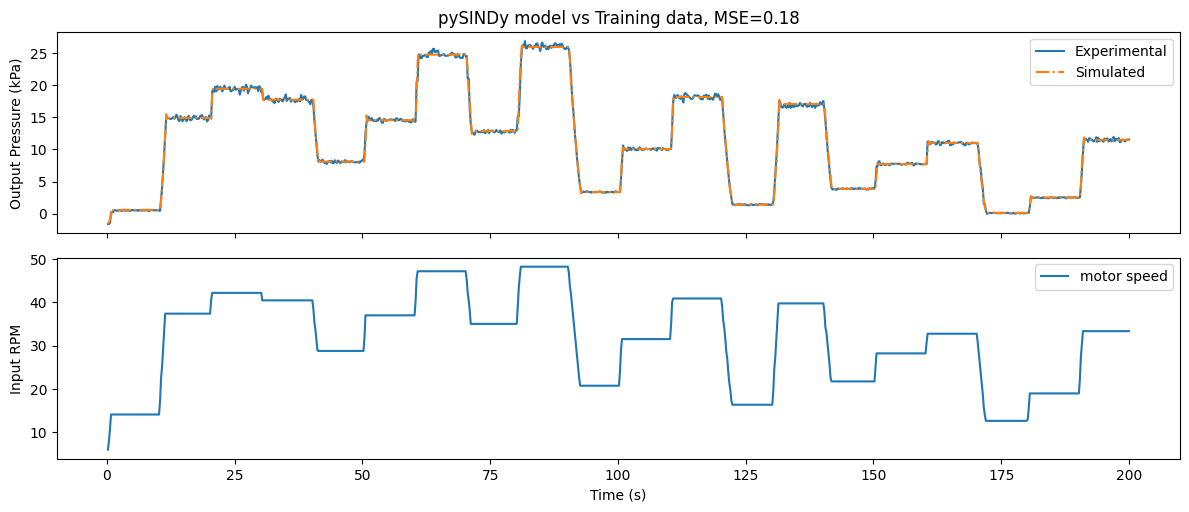

In [7]:
# Plot Actual train/test data v/s simulated data
plot_exp(u, x, sim, t, 'train', plt_range=1000)

In [12]:
t, u, x = data_gen('test_data.csv')
sim = sim_model(model, t, u, x)

Feature vector:  ['1', 'x', 'u', 'x^2', 'x u', 'u^2']


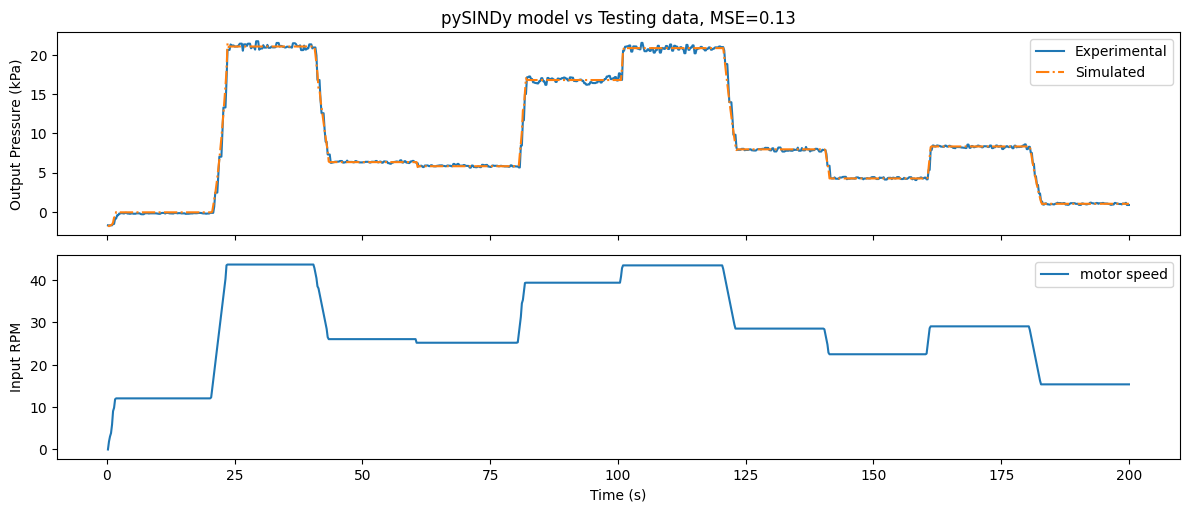

In [32]:
plot_exp(u, x, sim, t, 'test', plt_range=1000)

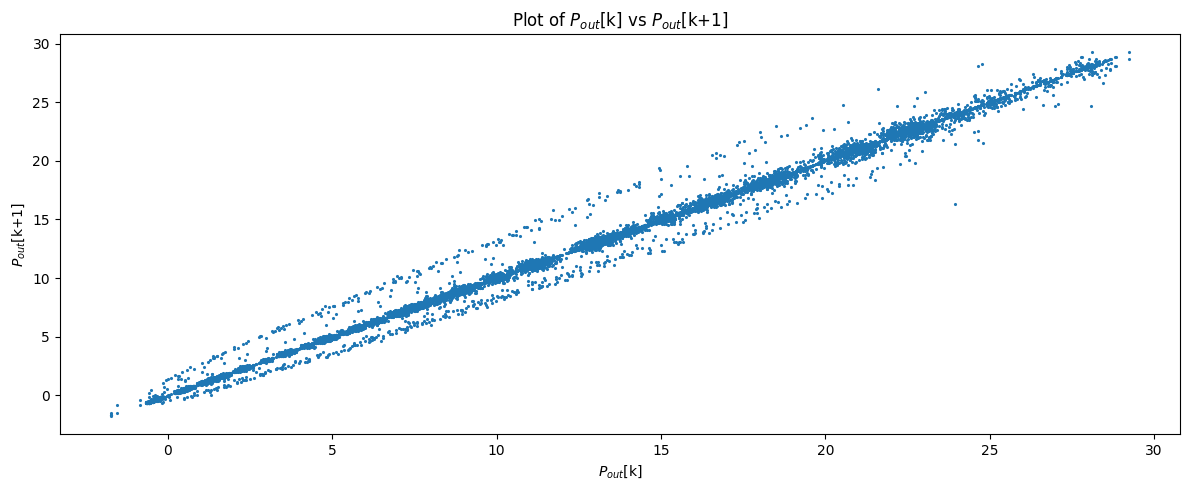

In [30]:
pout_shifted_plot(sim, 'test')

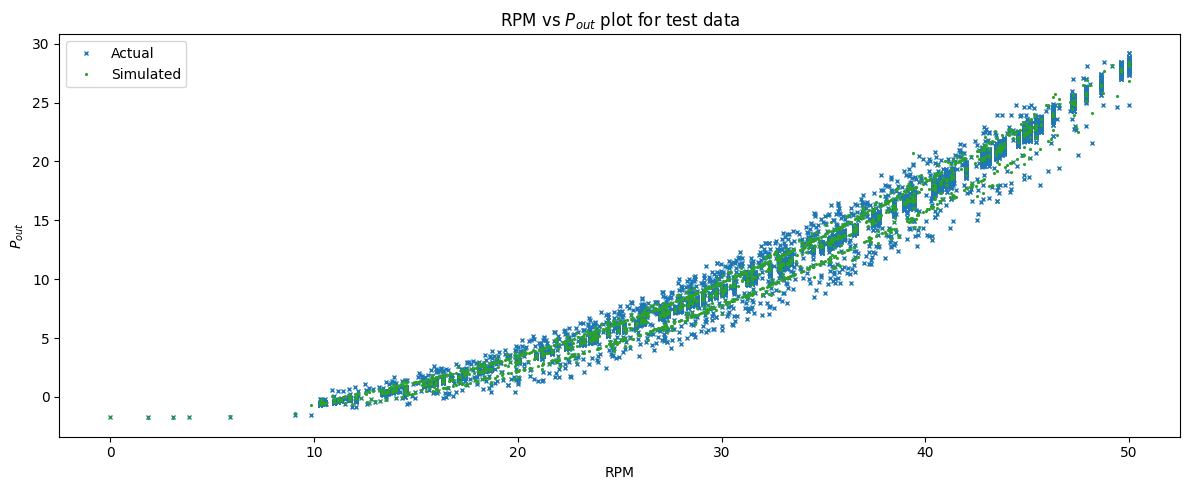

In [31]:
pout_rpm_plot(sim, plot_type='test')

# SIMO PySINDy Model

In [4]:
# get train data for inlet valve and suction pressure
fp = 'simo_data.csv'

sim_out = pd.DataFrame(pd.read_csv(fp, header=0, names=['t', 'rpm', 'p_inlet', 'p_out', 'flow_rate']))
sim_out

,t,rpm,p_inlet,p_out,flow_rate
0,0.1,33.298,-0.074043,-0.012672,0
1,0.2,32.666,-0.059242,-0.012672,0
2,0.3,31.985,-0.059242,-0.012672,0
3,0.4,31.262,-0.355450,-0.012672,0
4,0.5,30.505,-0.355450,0.012672,0
...,...,...,...,...,...
1995,199.6,51.762,-5.642600,28.436000,25
1996,199.7,51.811,-6.220200,28.436000,25
1997,199.8,51.636,-6.220200,30.260000,25
1998,199.9,51.254,-6.190600,30.793000,25


Text(0.5, 0, 'Time (s)')

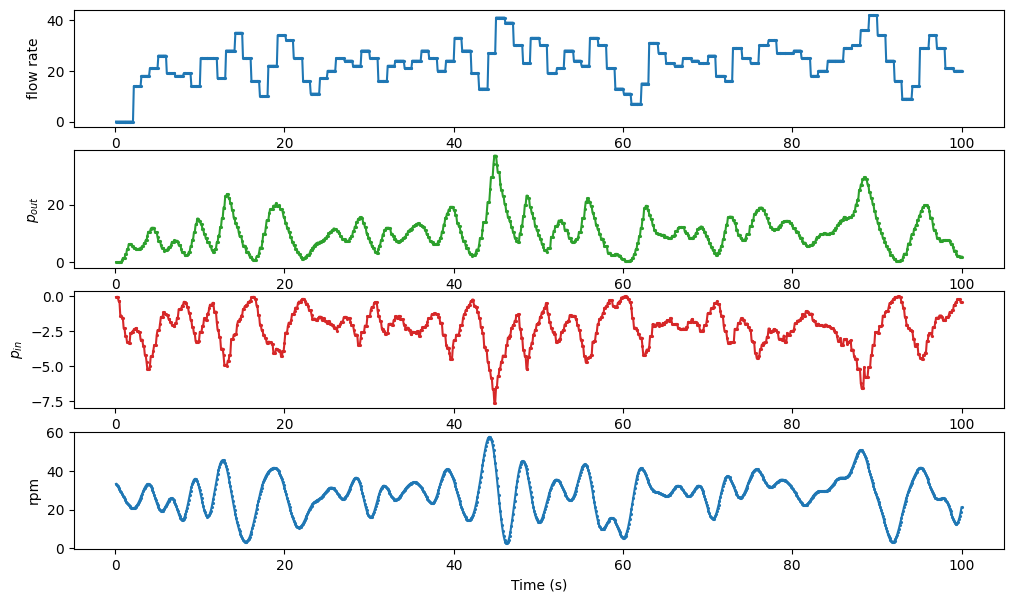

In [3]:

fig, ax = plt.subplots(4, 1, figsize=(12, 7))

ax[3].plot(sim_out.t[:1000], sim_out.rpm[:1000], marker='.', markersize=2.5, color='tab:blue')
ax[1].plot(sim_out.t[:1000], sim_out.p_out[:1000], marker='.', markersize=2.5,color='tab:green')
ax[2].plot(sim_out.t[:1000], sim_out.p_inlet[:1000], marker='.', markersize=2.5, color='tab:red')
ax[0].plot(sim_out.t[:1000], sim_out.flow_rate[:1000], marker='.', markersize=2.5)

ax[3].set_ylabel('rpm')
ax[1].set_ylabel(r'$p_{out}$')
ax[2].set_ylabel(r'$p_{in}$')
ax[0].set_ylabel('flow rate')
ax[3].set_xlabel('Time (s)')


In [264]:
# create x and u arrays
x = np.array([sim_out.p_out, sim_out.p_inlet, sim_out.flow_rate]).T
u = np.array([sim_out.rpm]).T
np.shape(x)

ratio = 0.8
split_idx = int(ratio*np.shape(x)[0])

train_data = np.array([x[:split_idx, i] for i in range(np.shape(x)[1])]).T
test_data = np.array([x[split_idx+1:, i] for i in range(np.shape(x)[1])]).T
u_train = u[:split_idx]
u_test = u[split_idx+1:]

In [298]:

Ts = 0.1

diff_method = ps.SmoothedFiniteDifference() # Finite difference method to reduce noise in derivative matrix x'
feature_lib = ps.PolynomialLibrary(degree=2, include_interaction=False) # feature vector of polynomials upto degree 2
# include interaction = true will allow products like x1*x2.

opt = ps.STLSQ(threshold=0.0001) # threshold indicates how much sparsification we need



model = ps.SINDy(
    discrete_time=True,
    optimizer=opt,
    feature_library=feature_lib,
    differentiation_method=diff_method,
    feature_names=['p_out', 'p_in', 'flow_rate', 'u'],
)

model.fit(u=u_train, x=train_data ,t=Ts)
print("Model Equation(s): ")
model.print()

Model Equation(s): 
(p_out)[k+1] = -0.355 1 + 0.786 p_out[k] + -0.542 p_in[k] + 0.053 flow_rate[k] + -0.038 u[k] + -0.004 p_in[k]^2 + -0.001 flow_rate[k]^2 + 0.002 u[k]^2
(p_in)[k+1] = -0.178 1 + 0.042 p_out[k] + 1.059 p_in[k] + 0.003 flow_rate[k] + 0.008 u[k] + -0.002 p_out[k]^2 + 0.039 p_in[k]^2 + -0.001 u[k]^2
(flow_rate)[k+1] = 1.245 1 + 0.464 p_out[k] + 0.901 p_in[k] + 0.885 flow_rate[k] + 0.015 u[k] + -0.007 p_out[k]^2 + 0.104 p_in[k]^2 + -0.001 flow_rate[k]^2 + -0.001 u[k]^2


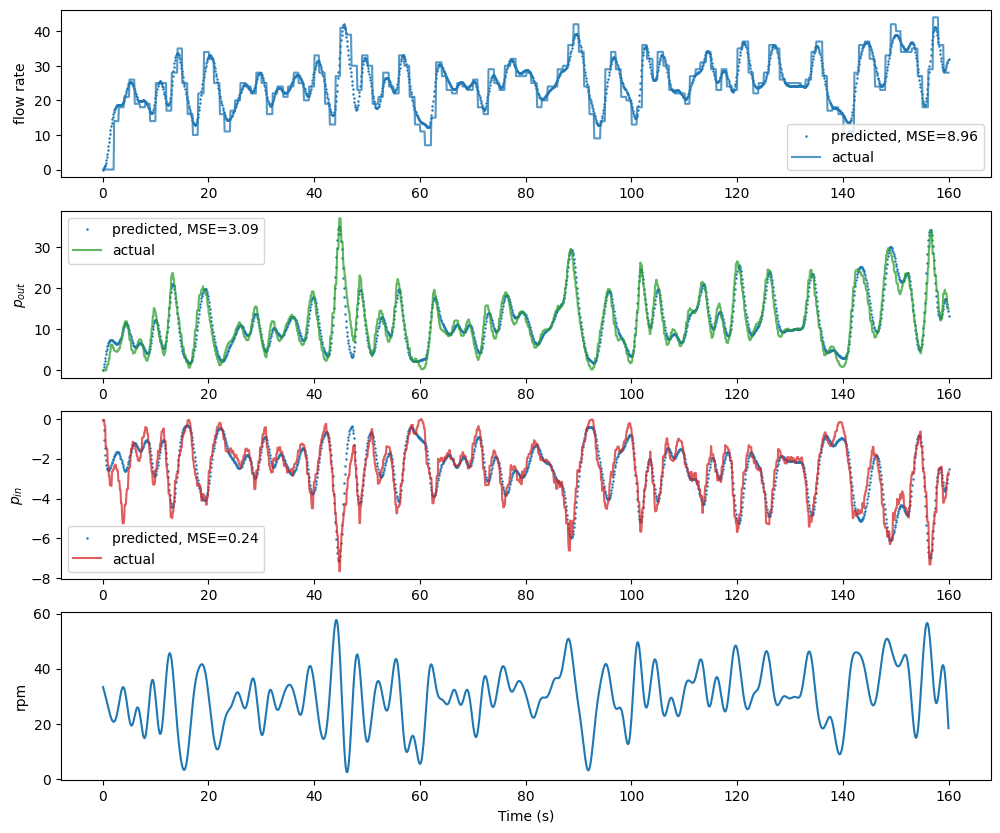

In [334]:
sim = model.simulate(x0=train_data[0,:], t=len(u_train),u=u_train)
plot_simo(sim_out, sim, split_idx, 'train')

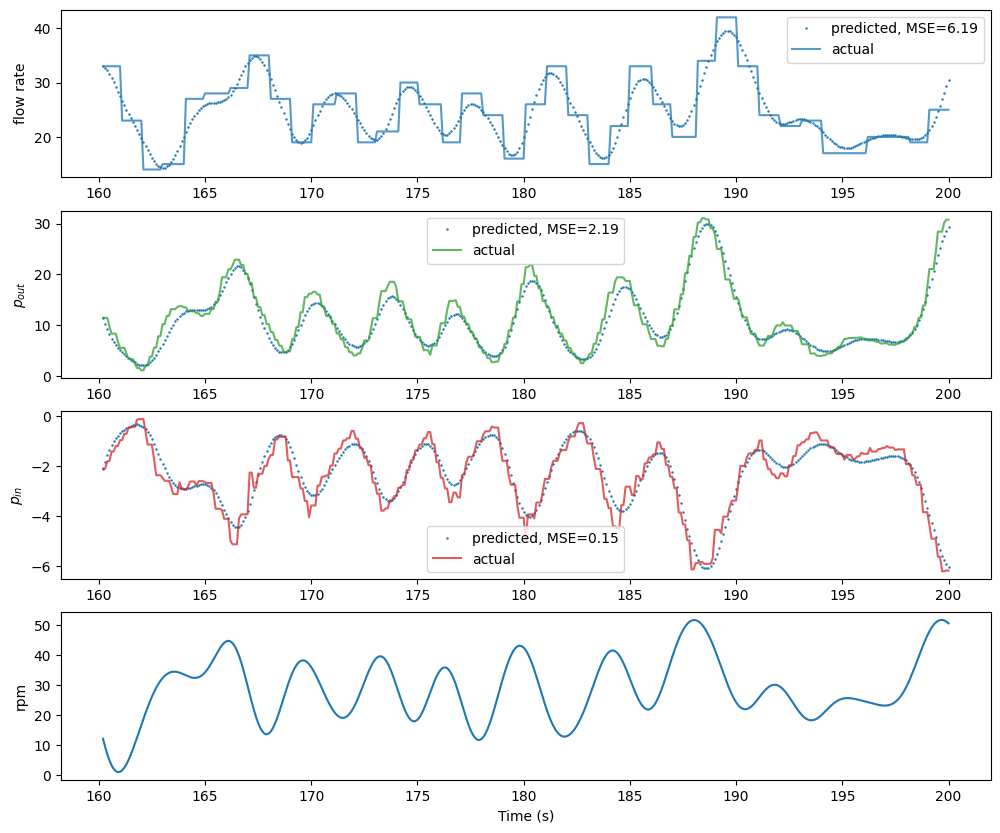

In [335]:
sim = model.simulate(x0=test_data[0,:], t=len(u_test),u=u_test)
plot_simo(sim_out, sim, split_idx, 'test')